In [54]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from imutils import paths
import imutils
import random as rd
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import img_to_array, load_img
from keras.losses import MAE
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [16]:
import opendatasets as od

In [17]:
od.download("https://www.kaggle.com/datasets/kaiska/apparel-dataset")

Skipping, found downloaded files in ".\apparel-dataset" (use force=True to force download)


In [18]:
datadir='apparel-dataset'

files = sorted(list(paths.list_images(datadir)))

rd.shuffle(files)

images = []
labels = []
dims = (96, 96, 3)

for filename in files:
    img = cv.imread(filename)
    img = cv.resize(img, (96, 96))
    img = img_to_array(img)
    images.append(img)
    
    lbl = filename.split(os.path.sep)[-2].split("_")
    labels.append(lbl)
    
images = np.array(images, dtype="float") / 255
labels = np.array(labels)

In [19]:
images.shape

(16170, 96, 96, 3)

In [20]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)

print("Class labels:")
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i + 1, label))
print("")
print("Example binarized label for black dress:")
print(mlb.transform([("black", "dress")]))

Class labels:
1. black
2. blue
3. brown
4. dress
5. green
6. hoodie
7. pants
8. pink
9. red
10. shirt
11. shoes
12. shorts
13. silver
14. skirt
15. suit
16. white
17. yellow

Example binarized label for black dress:
[[1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [21]:
(train_img, test_img, train_lbl, test_lbl) = train_test_split(images, labels, test_size=0.3, random_state=42)
print("Shape of train images:", train_img.shape)
print("Shape of test images:", test_img.shape)
print("Shape of train labels:", train_lbl.shape)
print("Shape of test labels:", test_lbl.shape)

Shape of train images: (11319, 96, 96, 3)
Shape of test images: (4851, 96, 96, 3)
Shape of train labels: (11319, 17)
Shape of test labels: (4851, 17)


In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(96, 96, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(3, 3),  
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(17, activation='sigmoid')
])

model.compile(loss=MAE, optimizer= Adam(learning_rate=1e-3, decay=0.00005),
              metrics=["accuracy"])

In [23]:
checkpoint = ModelCheckpoint('best_model.h5', save_best_only = True, monitor = 'val_loss', verbose = 1)

In [24]:
to_json = model.to_json()

with open('model.json', 'w') as f:
    f.write(to_json)

In [26]:
history = model.fit(train_img, train_lbl,
                    batch_size=64,
                    validation_data = (test_img, test_lbl), 
                    epochs = 150, verbose = 1, 
                    callbacks = [checkpoint])

Epoch 1/150
177/177 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.4616
Epoch 1: val_loss improved from inf to 0.13374, saving model to best_model.h5
177/177 [==============================] - 387s 2s/step - loss: 0.0591 - accuracy: 0.4616 - val_loss: 0.1337 - val_accuracy: 0.0550
Epoch 2/150
177/177 [==============================] - ETA: 0s - loss: 0.0363 - accuracy: 0.4934
Epoch 2: val_loss improved from 0.13374 to 0.07487, saving model to best_model.h5
177/177 [==============================] - 290s 2s/step - loss: 0.0363 - accuracy: 0.4934 - val_loss: 0.0749 - val_accuracy: 0.2608
Epoch 3/150
177/177 [==============================] - ETA: 0s - loss: 0.0309 - accuracy: 0.5216
Epoch 3: val_loss improved from 0.07487 to 0.04049, saving model to best_model.h5
177/177 [==============================] - 529s 3s/step - loss: 0.0309 - accuracy: 0.5216 - val_loss: 0.0405 - val_accuracy: 0.4063
Epoch 4/150
177/177 [==============================] - ETA: 0s - loss: 

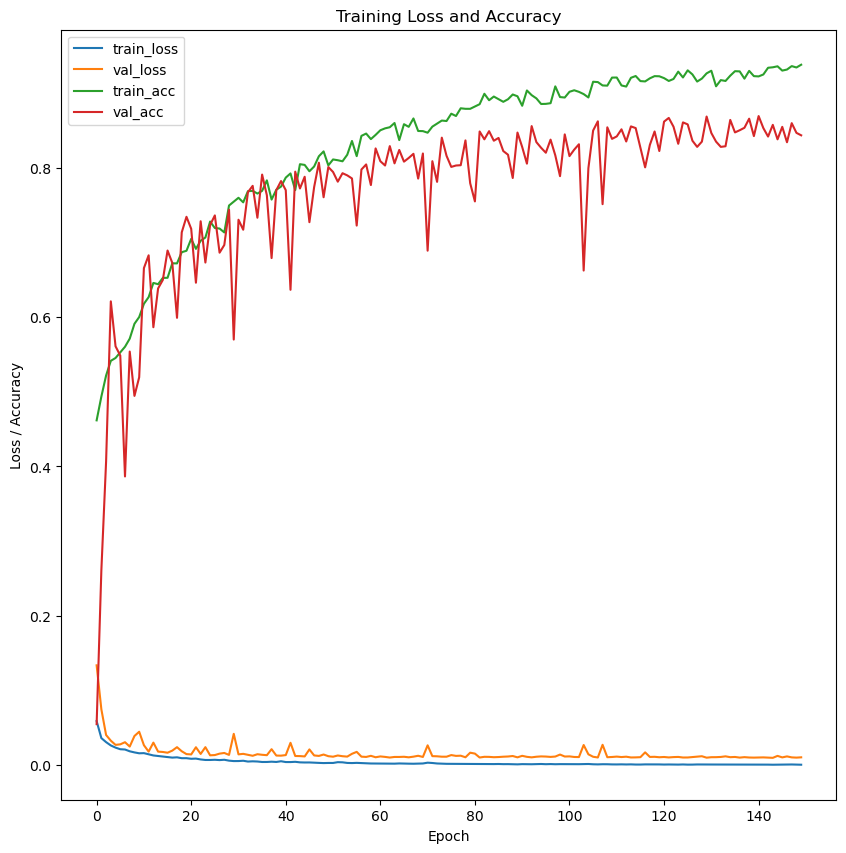

In [27]:
plt.figure(figsize=(10,10))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc="best")

In [52]:
def predict(path):
    
    img = cv.imread(path)
    img = cv.resize(img, (96, 96))
    img = img.astype("float") / 255.0
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)[0]
    y = np.argsort(pred)[::-1][:2]
    
    output = load_img(path)
    plt.imshow(output)
    
    return plt.xlabel(' '.join(mlb.classes_[y]))

1/1 [==============================] - 0s 82ms/step


Text(0.5, 0, 'brown shoes')

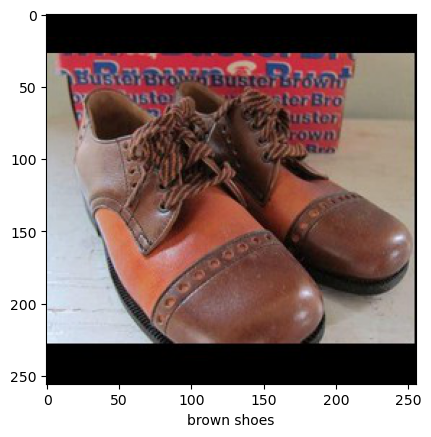

In [64]:
predict('apparel-dataset/brown_shoes/54.jpg')

1/1 [==============================] - 0s 80ms/step


Text(0.5, 0, 'blue shirt')

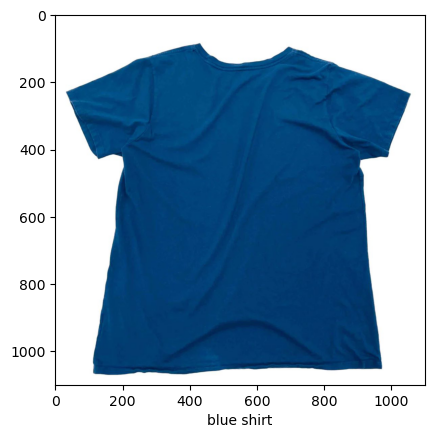

In [65]:
new_img='bluee.jpg'
predict(new_img)